In [1]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy import stats

dl = DataLib("SignalData")

# Outline
What is this indicator? 
- Bond premium is simply the difference between long rates and short rates, i.e. the slope of the yield curve. 
- When the yield curve is steep, yields on longer-term securities are higher than yields on shorter-term securities - a signal of strong future economic growth. 
- When the difference is small or inverted (short-term higher than longer-term), this can be interpreted as warning of an oncoming recession.

What should we expect it to do? 
- We might expect positive correlation between bond premium and bond returns. If we take a high premium to signify an upcoming period of economic growth, we would expect bond returns to increase and interest rates rise to curb inflation. 

# Exploration

In [2]:
# Pull all the necessary dataframes to avoid duplicate code. 
bri = dl.pull("BondRetIdx/LocalFX")
lr = dl.pull('LongRates')
sr = dl.pull('ShortRates')

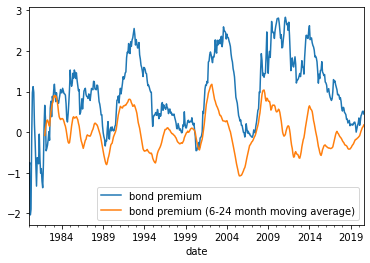

In [3]:
# Get bond premium. 
premium = lr - sr

# Get an oscillator: an 24-6 rolling average. 
# This oscillator better captures local changes. 
premium_sma_diff = premium.rolling(6).mean() - premium.rolling(24).mean()

# Plot the premium curve and the 6-24 difference.
premium['USA'].plot(label='bond premium')
premium_sma_diff['USA'].plot(label='bond premium (6-24 month moving average)')
plt.legend()

In [4]:
# Get the rolling average of the monthly change in bond returns. 
bri_chg = bri.resample('M').mean().pct_change()
bri_chg_sma = bri_chg.rolling(24).mean()

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

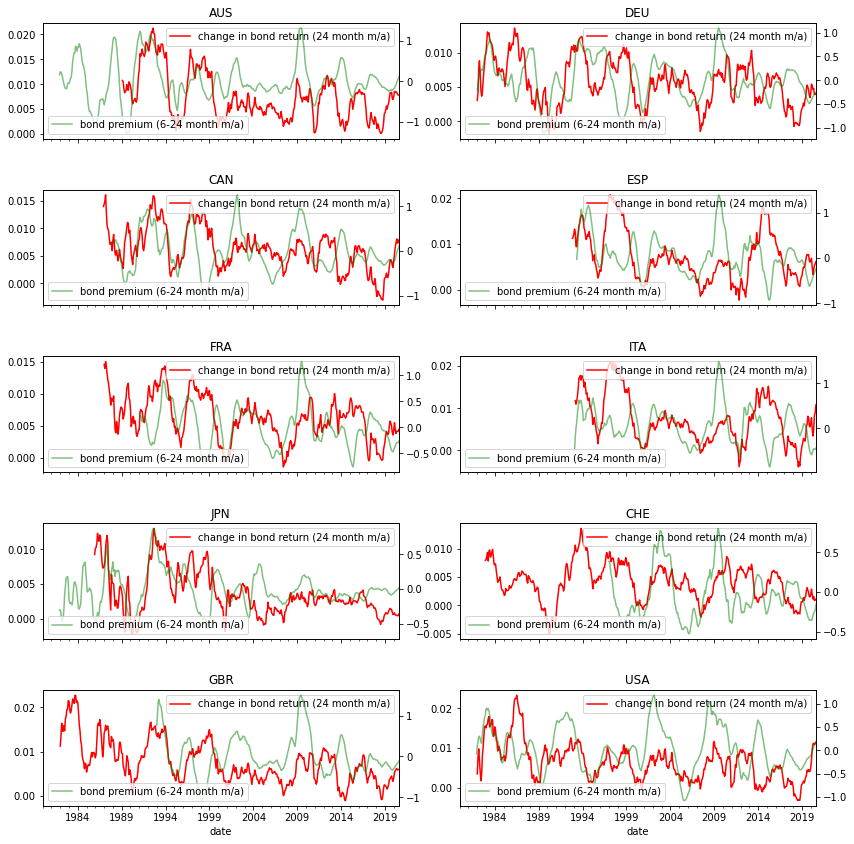

In [5]:
# For every country, plot the bond returns alongside our oscillator.
fig, axs = plt.subplots(5, 2, figsize=(12, 12))
fig.tight_layout(pad=3)

for i, country in enumerate(bri.columns.values):
    ax1 = axs[i//2][i%2]
    ax2 = ax1.twinx()
    bri_chg_sma[country].plot(ax=ax1, color='red', title=country, label='change in bond return (24 month m/a)')
    premium_sma_diff[country].plot(ax=ax2, color='green', label='bond premium (6-24 month m/a)', alpha=0.5)
    ax1.legend(loc=1)
    ax2.legend(loc=3)

<AxesSubplot:xlabel='country'>

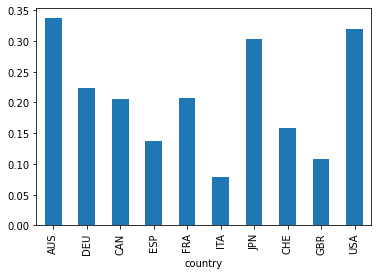

In [6]:
# Get the correlation between our oscillator and bond returns. 
correlation = premium_sma_diff.corrwith(bri_chg_sma)
correlation.plot.bar()

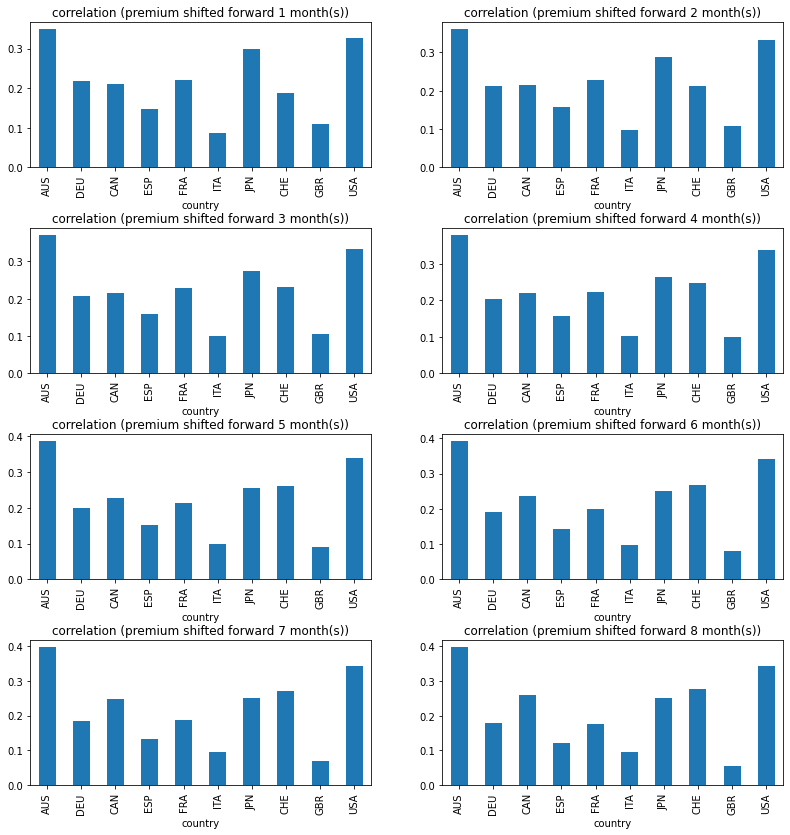

In [7]:
# Let's try and lag our indicator and see if the correlation improves. 
premium_sma_diff_shifted = premium_sma_diff

# Plot the correlation. 
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
fig.tight_layout(pad=4)
for i, shift in enumerate(range(1, 9)): 
    ax = axs[i//2][i%2]
    premium_sma_diff_shifted = premium_sma_diff.shift(shift)
    correlation = premium_sma_diff_shifted.corrwith(bri_chg_sma)
    correlation.plot.bar(ax=ax, title='correlation (premium shifted forward {} month(s))'.format(shift))

# Building the indicator

In [8]:
# Get bond premium. 
premium = lr - sr

# Get the mean across all countries of the 12-month rolling average of monthly change.
premium_average = premium.rolling(12).mean().mean(axis=1)

# Subtract this mean from the monthly change.
premium_subglobal = premium.subtract(premium_average, axis=0)

# Turn the change into a zscore. 
sma = premium_subglobal.rolling(12).mean()
std = premium_subglobal.rolling(12).std()
zscore = (premium_subglobal - sma) / std

In [9]:
# Save the indicator. 
dl.write_data('premium_zscore', zscore)

In [10]:
for country in bri.columns.values: 
    print('{} zscore/return corr:'.format(country), zscore[country].corr(bri_chg_sma[country]))

AUS zscore/return corr: 0.08422870343280563
DEU zscore/return corr: 0.0423881707690717
CAN zscore/return corr: 0.10641221173814608
ESP zscore/return corr: 0.03829376780717289
FRA zscore/return corr: -0.11566021249879578
ITA zscore/return corr: -0.009320974105173045
JPN zscore/return corr: -0.12858672506331126
CHE zscore/return corr: -0.10915178251783636
GBR zscore/return corr: -0.11253048189166329
USA zscore/return corr: 0.08692445325063754


# Return stream

In [11]:
zscore.index

PeriodIndex(['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06',
             '1980-07', '1980-08', '1980-09', '1980-10',
             ...
             '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04',
             '2020-05', '2020-06', '2020-07', '2020-08'],
            dtype='period[M]', name='date', length=488, freq='M')

<AxesSubplot:xlabel='date'>

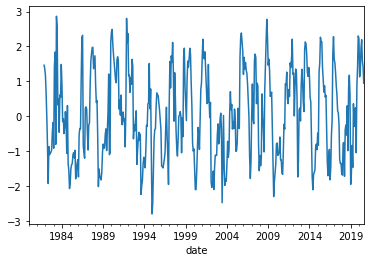

In [12]:
zscore['AUS'].plot()

In [13]:
# Clip the signal to between -2 and 2, then scale to [-1,1]
signal = (1 * zscore).clip(upper=2, lower=-2) / 2

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

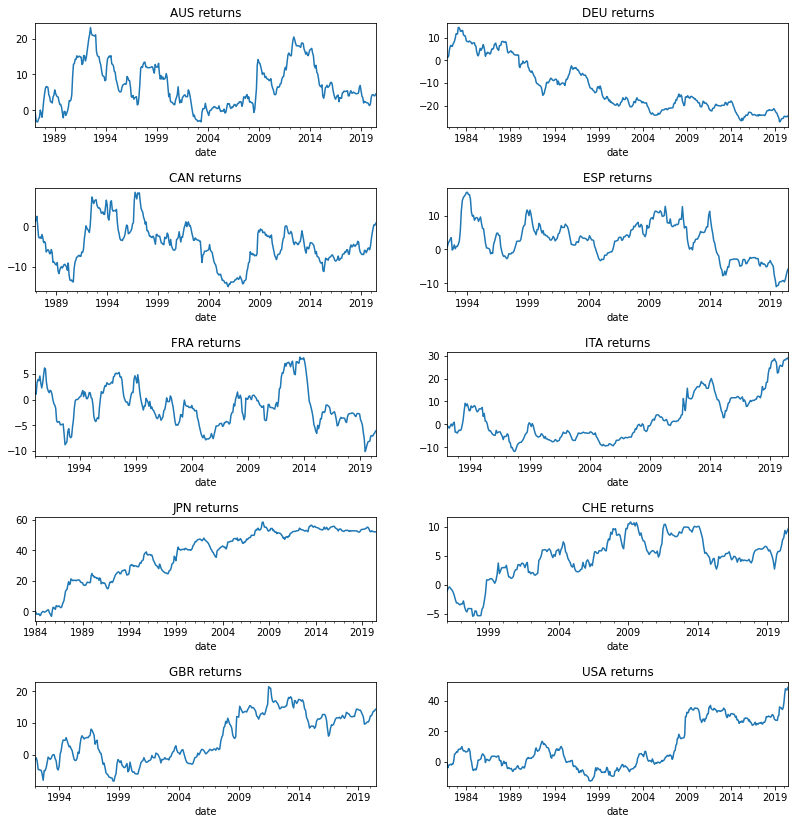

In [14]:
# Calculate the returns. 
returns = bri.resample('M').mean().pct_change().loc[signal.index].shift(-1)
returns = (signal * returns)

# Plot the return stream for every country. 
fig, axs = plt.subplots(5, 2, figsize=(12, 12))
fig.tight_layout(pad=4)
for i, country in enumerate(bri.columns.values):
    ax = axs[i//2][i%2]

    cumul_returns = ((returns[country].dropna() + 1).cumprod() - 1) * 100
    cumul_returns.plot(ax=ax, title='{} returns'.format(country))

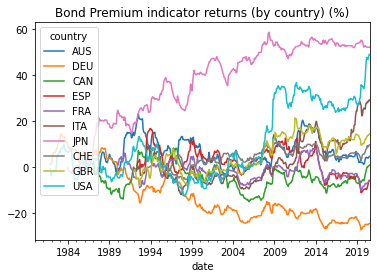

<AxesSubplot:title={'center':'Bond Premium returns (total) (%)'}, xlabel='date'>

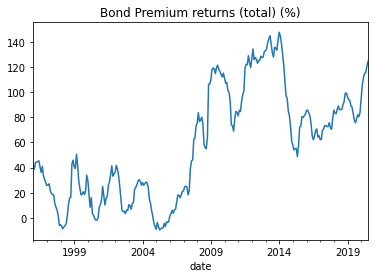

In [15]:
# Plot returns on the same axis. 
cumul_returns = ((returns + 1).cumprod() - 1) * 100
cumul_returns.plot(title='Bond Premium indicator returns (by country) (%)')
plt.show()

# Plot the sum. 
cumul_returns.dropna().sum(axis=1).plot(title='Bond Premium returns (total) (%)')